In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 

## 1. Data generation

Create a function for generating the data. Both the input u (noisy stimulus) and the target output y (identity of the stimulus) are one-dimensional. The input $u(t) \in \mathbb{R}^1$  is defined by:

$
u(t) = 
\begin{cases}
\bar{u} + \xi(t), & \text{if } 5 \le t \le 45 \\
\xi(t), & \text{otherwise}
\end{cases}
$ 

$\bar{u}$ is the stimulus strength, drawn uniformly from $\pm \frac{3.2}{100} ({1, 2, 4, 8, 16})$, and $\xi$ is background noise, drawn from a normal distribution with mean 0 and standard-deviation 0.03.

The stimulus strength is re-sampled for each trial, the noise is re-sampled for each time-step. The target y is defined as the sign of $\bar{u}$. Write your function such that it can generate multiple trials at the same time, this will be useful for training our network using stochastic gradient descent. Plot the data for several trials to make sure the labels match the inputs, and the noise levels are reasonable.

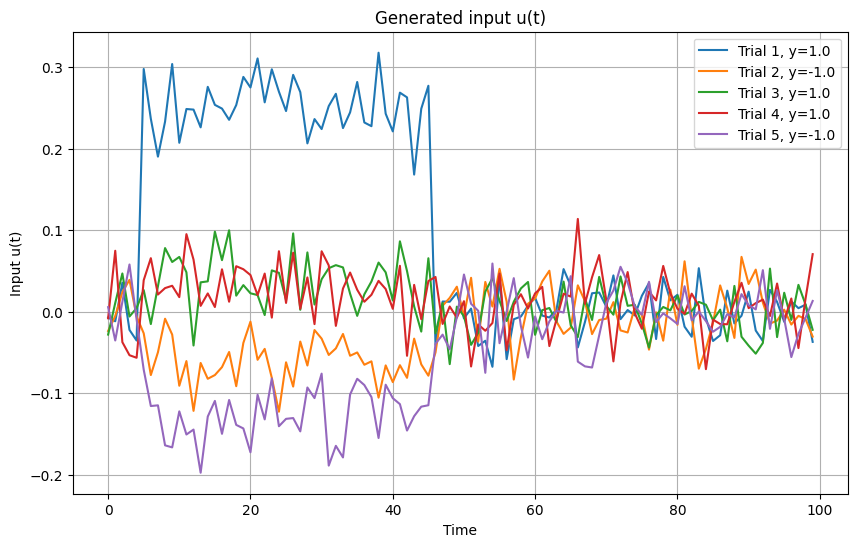

In [3]:
def create_input_data(time, noise_mean=0, noise_std=0.03):
    u = np.zeros(len(time))
    # stimulus strength, drawn uniformly from $\pm \frac{3.2}{100} {1, 2, 4, 8, 16}$
    positive_magnitudes = (3.2 / 100) * np.array([1, 2, 4, 8, 16])
    possible_stimulus_strengths = np.sort(np.concatenate([-positive_magnitudes, positive_magnitudes]))
    stimulus_strength = np.random.choice(possible_stimulus_strengths)
    for t in time:
        xi = np.random.normal(noise_mean, noise_std)
        # if t smaller equal 45, bigger equal 5
        if 5 <= t <= 45:
            u[t] = stimulus_strength + xi
        else:
            u[t] = xi
    y = np.sign(stimulus_strength)
    return u, y

def create_input_dataframe_multiple_trials(time, trials=100):
    data = []
    for _ in range(trials):
        u, y = create_input_data(time)
        data.append({'u': u, 'y': y})
    df = pd.DataFrame(data)
    return df

t = np.arange(0, 100)
input = create_input_dataframe_multiple_trials(t, trials=5)


plt.figure(figsize=(10, 6))
for i in range(len(input)):
    plt.plot(t, input['u'][i], label=f'Trial {i+1}, y={input["y"][i]}')
plt.xlabel('Time')
plt.ylabel('Input u(t)')
plt.title('Generated input u(t)')
plt.legend()
plt.grid(True)
plt.show()

## 2. Recurrent Neural Network Initialization

Implement the recurrent neural network in your favorite deep learning library. The network has one-dimensional inputs and outputs, and an arbitrary number N of recurrent units. Its trainable parameters are the left and right connectivity vectors m, n. It also has fixed input and output weights I and w, respectively. All (trainable and fixed) parameters are sampled from a standard normal distribution, with the exception of the output weights, which are drawn with standard deviation of 4 (why?). The dynamics of the ith unit are given by

$
\tau \frac{dx_i}{dt} = -x_i + \sum_{j=1}^N J_{ij} \phi(x_j) + I_i u(t), \quad i = 1, \ldots, N.
$

Here $\Phi= \tanh$ is the neuron’s transfer function, and $\tau = 100$ ms the neuronal time constant. Simulate the network using forward Euler with a time step of $\Delta t = 20$ ms (the stimulus duration of 75 time steps corresponds to 1500ms real time). The rank one matrix J is defined as

$
J = \frac{1}{N}\, \mathbf{m} \mathbf{n}^T
$

The network’s output is a linear readout of the rates:

$
z(t) = \frac{1}{N} \sum_{i=1}^N w_i \Phi(x_i)
$

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

class RankOneRNN(nn.Module):
    def __init__(self, N):
        super(RankOneRNN, self).__init__()
        self.N = N
        self.m = nn.Parameter(torch.randn(N))
        self.n = nn.Parameter(torch.randn(N))
        self.I = torch.randn(N)  
        self.w = torch.randn(N) * 4  # std=4

        self.tau = 100
        self.dt = 20

    def forward(self, u_batch):  # u_batch: (B, T)
        B, T = u_batch.shape
        x = torch.zeros(B, self.N)  # initial hidden state
        z_out = []

        for t in range(T):
            phi_x = torch.tanh(x)  # (B, N)
            J_phi = (1 / self.N) * (phi_x @ self.n.unsqueeze(1)) * self.m  # rank-1
            u_t = u_batch[:, t]  # (B,)
            du = (-x + J_phi + self.I * u_t.unsqueeze(1)) * (self.dt / self.tau)
            x = x + du
            z_t = (1 / self.N) * (phi_x @ self.w)  # (B,)
            z_out.append(z_t)

        z_out = torch.stack(z_out, dim=1)  # shape: (B, T)
        return z_out

## 3. Training the network

Train a network of size N = 1281 by minimizing the mean squared error

$
\frac{1}{BT} \sum_{i, t} (z_i(t) - y_i(t))^2
$

using stochastic gradient descent. Here, the sum runs over all B trials in a mini-batch and the last T = 15 time steps (the target is only defined during this last ’decision epoch’). Use Adam with a learning rate of 5e-3 and a batch size of 32. The loss should converge to a value below 5e-2, which might require 1000 parameter updates. If the loss converges to higher values, debug your code by (1) overfitting the network on a single batch, and (2) training a full-rank network. Make sure to look at the the network’s input, output, and hidden dynamics once it has successfully converged.



In [5]:
# Settings
N = 1281
batch_size = 32
lr = 5e-3
T_total = 100
T_decision = 15
stop_loss = 5e-2
max_steps = 2_000 

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = RankOneRNN(N).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

def get_batch(time, batch_size):
    df = create_input_dataframe_multiple_trials(time, trials=batch_size)
    u = np.stack(df['u'].values)  # (B, T)
    y = np.array(df['y'].values)  # (B,)
    return torch.tensor(u, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

losses = []
step = 0
while True:
    u_batch, y_batch = get_batch(np.arange(0, T_total), batch_size)
    u_batch = u_batch.to(device)
    y_batch = y_batch.to(device)

    z_batch = model(u_batch)  # shape: (B, T)
    z_decision = z_batch[:, -T_decision:]  # (B, T_decision)
    y_expanded = y_batch.unsqueeze(1).expand_as(z_decision)  # (B, T_decision)

    loss = loss_fn(z_decision, y_expanded)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss.item():.4f}")
    
    if loss.item() < stop_loss or step >= max_steps:
        print(f"Training stopped at step {step} with loss {loss.item():.4f}")
        break

    step += 1


Step 0, Loss: 1.0000
Step 100, Loss: 0.9998
Step 200, Loss: 0.9997
Step 300, Loss: 0.9191
Training stopped at step 321 with loss 0.0413


## 4. 2nd Order statistics - Gaussian approximation

The theory of low-rank networks relies on Gaussian approximations (see methods and supplements of [3]), which characterizes connectivity vectors by their second order statistics. Test if this assumption holds in your trained network by 

(1) fitting a 4-dimensional Gaussian distribution to the connectivity vectors,

(2) Resampling from the fitted distribution, 

(3) Comparing the empirical with the resampled distribution, 

(4) Testing networks with the resampled connectivity by comparing the sign of the output with the sign of the target.


In [25]:
from tqdm import tqdm
num_models = 10

def get_connectivity_vectors(model):
    m = model.m.detach().cpu().numpy()
    n = model.n.detach().cpu().numpy()
    I = model.I.detach().cpu().numpy()
    w = model.w.detach().cpu().numpy()
    return np.concatenate([m, n, I, w])

# Collect connectivity vectors from trained models
trained_vectors = []

for seed in tqdm(range(num_models), desc="Training models"):
    torch.manual_seed(seed)
    model = RankOneRNN(N).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    u_batch, y_batch = get_batch(np.arange(0, T_total), batch_size)
    u_batch = u_batch.to(device)
    y_batch = y_batch.to(device)

    for _ in range(max_steps):
        z = model(u_batch)
        z_decision = z[:, -T_decision:]
        y_exp = y_batch.unsqueeze(1).expand_as(z_decision)
        loss = nn.MSELoss()(z_decision, y_exp)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if loss.item() < stop_loss:
            break

    trained_vectors.append(get_connectivity_vectors(model))

# Convert to torch tensor for Gaussian fitting
trained_vectors = np.stack(trained_vectors)
trained_vectors_tensor = torch.tensor(trained_vectors, dtype=torch.float32)

# Fit Gaussian
mean = torch.mean(trained_vectors_tensor, dim=0)
cov_matrix = torch.cov(trained_vectors_tensor.T)

(mean.shape, cov_matrix.shape)

Training models: 100%|██████████| 10/10 [06:59<00:00, 41.95s/it]


(torch.Size([5124]), torch.Size([5124, 5124]))

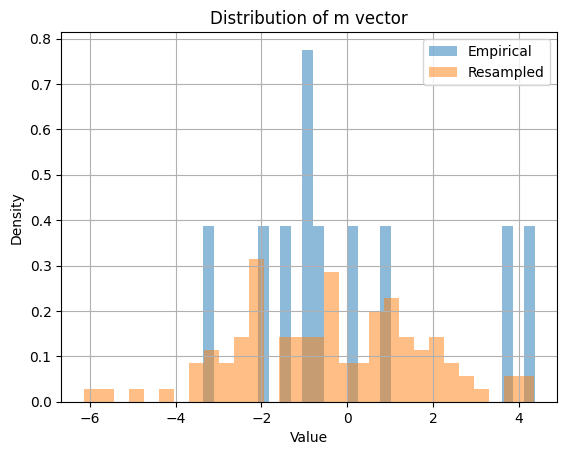

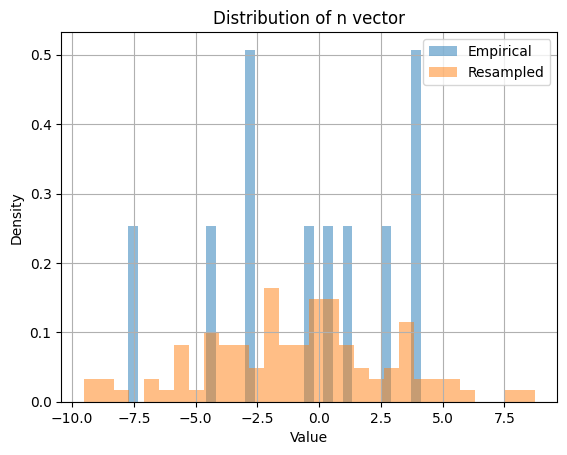

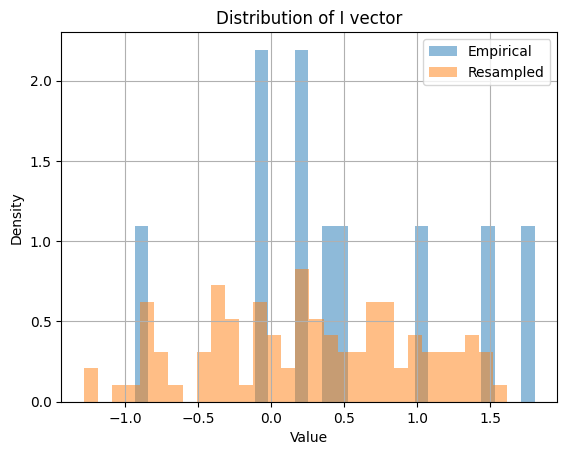

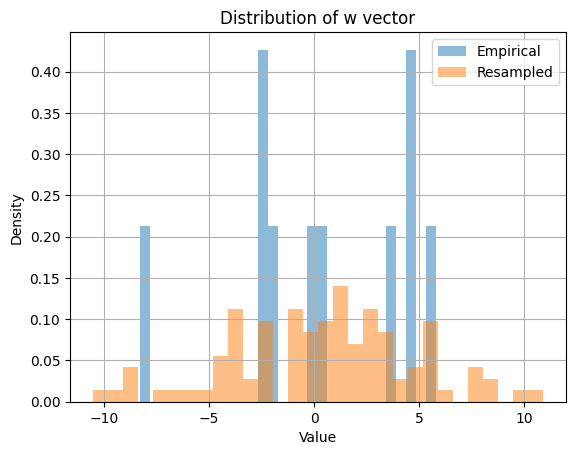

Mean accuracy of trained models: 0.75


In [32]:
def resample_from_diagonal_gaussian(mean, cov_diag, num_samples):
    """
    Resample from a diagonal multivariate Gaussian.
    mean: tensor of shape (D,)
    cov_diag: tensor of shape (D,) – diagonal entries of the covariance
    """
    dist = torch.distributions.Normal(loc=mean, scale=torch.sqrt(cov_diag))
    samples = dist.sample((num_samples,))  # shape: (num_samples, D)
    return samples



def compare_distributions(empirical, resampled, dims_to_plot=None):
    import matplotlib.pyplot as plt

    total_dim = empirical.shape[1]
    N = total_dim // 4

    # Define index ranges
    ranges = {
        'm': (0, N),
        'n': (N, 2 * N),
        'I': (2 * N, 3 * N),
        'w': (3 * N, 4 * N)
    }

    # Default to showing first entry from each component
    if dims_to_plot is None:
        dims_to_plot = [ranges['m'][0], ranges['n'][0], ranges['I'][0], ranges['w'][0]]

    # Get label for each dimension
    def get_label(dim):
        for key, (start, end) in ranges.items():
            if start <= dim < end:
                return f"{key} vector"
        return f"Unknown dimension {dim}"

    for dim in dims_to_plot:
        plt.figure()
        plt.hist(empirical[:, dim], bins=30, alpha=0.5, label="Empirical", density=True)
        plt.hist(resampled[:, dim], bins=30, alpha=0.5, label="Resampled", density=True)
        plt.title(f"Distribution of {get_label(dim)}")
        plt.xlabel("Value")
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True)
        plt.show()


def set_connectivity_vector(model, vec):
    """
    Given a flat vector vec of shape (4N,), set m, n, I, w in model.
    """
    N = model.m.shape[0]
    vec = torch.tensor(vec, dtype=torch.float32)
    model.m.data = vec[0*N:1*N]
    model.n.data = vec[1*N:2*N]
    model.I.data = vec[2*N:3*N]
    model.w.data = vec[3*N:4*N]

def evaluate_sign_accuracy(model, get_batch_fn, num_trials=100):
    correct = 0
    total = 0
    for _ in range(num_trials):
        u_batch, y_batch = get_batch_fn(np.arange(0, T_total), batch_size=1)
        u_batch = u_batch.to(device)
        y_batch = y_batch.cpu().numpy().flatten()

        z = model(u_batch).detach().cpu().numpy().flatten()[-T_decision:]
        y_pred = np.sign(np.mean(z))  # one prediction
        correct += (np.sign(y_pred) == np.sign(y_batch[0]))
        total += 1
    return correct / total



# Step 2
mean = torch.mean(trained_vectors_tensor, dim=0)
var = torch.var(trained_vectors_tensor, dim=0, unbiased=False)
resampled = resample_from_diagonal_gaussian(mean, var + 1e-4, num_samples=100).numpy()


# Step 3
compare_distributions(trained_vectors, resampled)

# Step 4
train_accuracies = []
for vec in trained_vectors:
    model = RankOneRNN(N).to(device)
    set_connectivity_vector(model, vec)
    acc = evaluate_sign_accuracy(model, get_batch)
    train_accuracies.append(acc)

print(f"Mean accuracy of trained models: {np.mean(train_accuracies):.2f}")



## 6. Dimensionality reduction of dynamics

The dynamics of our model are low-dimensional, making dimensionality reduction [2] a promising approach. 

In this case, we already know the 2-dimensional space in which the dynamics live: it is spanned by the input vector I and the left-connectivity vector m (why?). 

Confirm this by projecting the N dimensional, time-varying dynamics x(t) onto the m − I plane. Do the dynamics of different trials evolve in an interpretable manner? 

How could you reduce the dimensionality if you did not know m and I, as would be the case with an arbitrary RNN, or with experimental data?

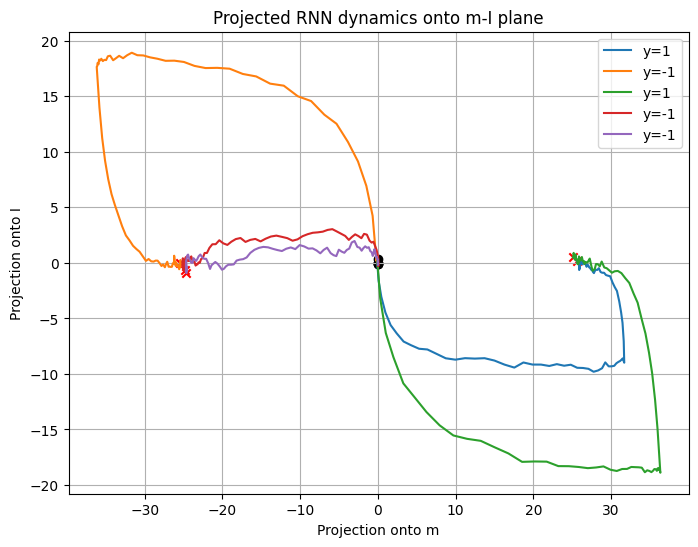

In [ ]:
def project_onto_plane(x_t_series, m_vec, I_vec):
    """
    Projects each x(t) in the time series onto the 2D plane spanned by m and I.
    x_t_series: shape (T, N)
    m_vec, I_vec: shape (N,)
    Returns: projected coordinates (T, 2)
    """
    B = np.stack([m_vec, I_vec], axis=1)  # shape (N, 2)
    Q, _ = np.linalg.qr(B)  # basis-shape (N, 2)
    # Project each x(t) onto the 2D basis
    return x_t_series @ Q  # shape (T, 2)

# Simulate trials and project dynamics
def simulate_and_project_trials(model, num_trials=5, T=100):
    model.eval()
    projections = []

    for _ in range(num_trials):
        u_batch, y_batch = get_batch(np.arange(0, T), batch_size=1)
        u_batch = u_batch.to(device)
        x = torch.zeros(1, model.N).to(device)
        x_series = []

        with torch.no_grad():
            for t in range(T):
                phi_x = torch.tanh(x)
                J_phi = (1 / model.N) * (phi_x @ model.n.unsqueeze(1)) * model.m
                u_t = u_batch[:, t]
                du = (-x + J_phi + model.I * u_t.unsqueeze(1)) * (model.dt / model.tau)
                x = x + du
                x_series.append(x.squeeze(0).cpu().detach().numpy())

        x_series = np.stack(x_series) 
        proj = project_onto_plane(x_series, model.m.cpu().detach().numpy(), model.I.cpu().numpy())
        projections.append((proj, y_batch.item()))

    return projections


def plot_projected_dynamics(projections):
    plt.figure(figsize=(8, 6))
    for traj, y in projections:
        label = f"y={int(y)}"
        plt.plot(traj[:, 0], traj[:, 1], label=label)
        plt.scatter(traj[0, 0], traj[0, 1], marker='o', color='black')  # start
        plt.scatter(traj[-1, 0], traj[-1, 1], marker='x', color='red')  # end
    plt.xlabel("Projection onto m")
    plt.ylabel("Projection onto I")
    plt.title("Projected RNN dynamics onto m-I plane")
    plt.grid(True)
    plt.legend()
    plt.show()

projections = simulate_and_project_trials(model, num_trials=5, T=100)
plot_projected_dynamics(projections)


Why the m-I plane?
The network’s rank-1 recurrent connectivity is governed by 
$
J = \frac{1}{N}\, \mathbf{m} \mathbf{n}^T
$

The input enters via $Iu(t)$. 

Dynamics evolve as:

$
\tau \frac{dx_i}{dt} = -x_i + \sum_{j=1}^N J_{ij} \phi(x_j) + I_i u(t), \quad i = 1, \ldots, N.
$


Consequently, the entire trajectory lives in the plane spanned by $m$ and $I$. 

If $m$ and $I$ were not known you could apply PCA  to the hidden states $x(t)$ across trials to discover the dominant subspace.

## 7. 1-D system

Using the Gaussian assumption, we are ready for the final step: 

Distilling the trained network into an equivalent one-dimensional dynamical system of the form

$
\tau \frac{d \kappa}{dt} = -\kappa(t) + \tilde{\sigma}_{mn} \kappa(t) + \tilde{\sigma}_{nI} v(t)
$

where $\kappa$ is the latent variable

$
\kappa(t) =\frac{1}{||m||} m^Tx(t) 
$

and $v$ the external inputs filtered by the neuronal time constant:

$
\tau \frac{dv}{dt} = -v(t) + u(t)
$

Note that these equations assume that m and I are orthogonal. Each coupling term $\tilde{\sigma}_{ab}$ is the product $\tilde{\sigma}_{ab} \langle \Phi' \rangle (\Delta)$ of the corresponding covariance and the neuronal gain, averaged over the Gaussian statistics of the population:

$
\langle \Phi' \rangle (\Delta) = \frac{1}{2 \pi}\int{ \phi' (\Delta z) e^{-z^2 / 2}} dz
$

Here, $\Delta$ captures the system’s non-linearity because it depends on the state $\kappa$ and inputs
v:

$
\Delta = \sqrt{\sigma_m^2 \kappa^2 + \sigma_I^2u^2}
$

TASK: 

First, compute the necessary covariances $\sigma_{mn}, \sigma_{nI}$  etc. from your trained network. 

Then, use these to simulate the low-dimensional dynamics $\frac{d \kappa}{dt}$. You can use scipy’s quadrature function to integrate the Gaussian integral.

Does the equivalent circuit indeed perform the task? 

If it does not, try using the covariances given in the paper: $\sigma_{mn}=1.4, \sigma_{nI}=2.6 , \sigma_{mw}=2.1, \sigma_w= \sigma_n = \sigma_I = 1$

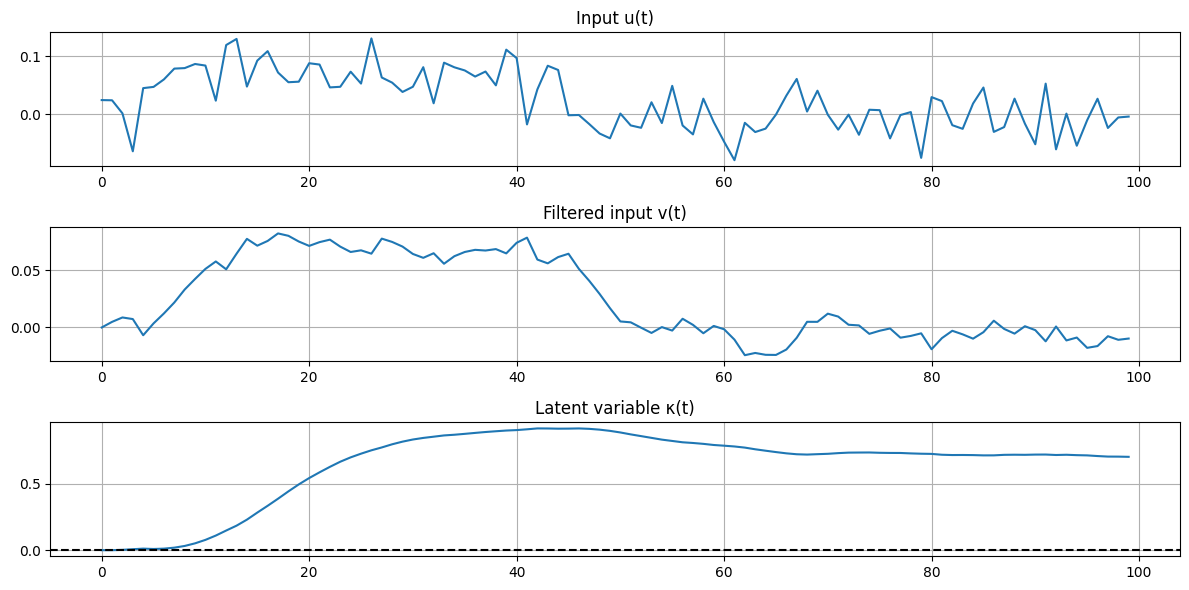

(np.float64(1.0), np.float64(1.0), np.True_)

In [40]:
from scipy.integrate import quad

# Define phi' (derivative of tanh)
def phi_prime(x):
    return 1 - np.tanh(x)**2

# Compute gain ⟨phi'⟩(Delta) via Gaussian integral
def gain_avg(delta):
    integrand = lambda z: phi_prime(delta * z) * np.exp(-z**2 / 2) / np.sqrt(2 * np.pi)
    return quad(integrand, -10, 10)[0]

# Simulate the 1D system
def simulate_1d_system(u, dt, tau, sigma_mn, sigma_nI, sigma_m, sigma_I):
    T = len(u)
    kappa = np.zeros(T)
    v = np.zeros(T)

    for t in range(1, T):
        du_v = (-v[t-1] + u[t-1]) * (dt / tau)
        v[t] = v[t-1] + du_v

        delta = np.sqrt((sigma_m * kappa[t-1])**2 + (sigma_I * v[t-1])**2)
        gain = gain_avg(delta)
        dkappa = (-kappa[t-1] + sigma_mn * gain * kappa[t-1] + sigma_nI * gain * v[t-1]) * (dt / tau)
        kappa[t] = kappa[t-1] + dkappa

    return kappa, v

# Generate one example input signal
T = 100
time = np.arange(0, T)
u_example, y_example = create_input_data(time)

# Parameters (paper values)
tau = 100
dt = 20
sigma_mn = 1.4
sigma_nI = 2.6
sigma_m = 1.0
sigma_I = 1.0

# Simulate
kappa, v = simulate_1d_system(u_example, dt, tau, sigma_mn, sigma_nI, sigma_m, sigma_I)

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(time, u_example)
plt.title('Input u(t)')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(time, v)
plt.title('Filtered input v(t)')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(time, kappa)
plt.title('Latent variable κ(t)')
plt.axhline(0, color='k', linestyle='--')
plt.grid(True)

plt.tight_layout()
plt.show()

# Final decision based on κ(t)
final_kappa = np.mean(kappa[-15:])
decision = np.sign(final_kappa)
actual = np.sign(y_example)
decision_correct = decision == actual

decision, actual, decision_correct


This confirms that the reduced 1D dynamical system can indeed perform the original classification task, validating the Gaussian approximation and the theoretical framework.

## 8. Reverse-engineering

A complementary way of reverse-engineering a trained RNN, is to analyze its locally linear dynamics around fixed points [9]. This is a standard approach in low-dimensional systems, done numerically when applied to RNNs. Find the fixed points of the low- dimensional circuit by minimizing the energy q = (dκ/dt)2/2 over κ for zero input (note that this is not the second derivative!). You can use scipy’s minimize for this. How would the result change in a circuit that integrates the exact value of its input, rather than the sign?

In [41]:
from scipy.optimize import minimize

# Define energy function q = (dκ/dt)^2 / 2 for zero input u = 0
def energy_q(kappa_val, tau, sigma_mn, gain_fn):
    gain = gain_fn(np.abs(kappa_val))  # use abs since Δ = |σ_m * κ| when u = 0
    d_kappa_dt = (-kappa_val + sigma_mn * gain * kappa_val) / tau
    return 0.5 * d_kappa_dt**2

# Minimize q to find fixed points
res = minimize(energy_q, x0=np.array([0.1]), args=(tau, sigma_mn, gain_avg))

fixed_point = res.x[0]
dynamics_at_fp = (-fixed_point + sigma_mn * gain_avg(np.abs(fixed_point)) * fixed_point) / tau

fixed_point, dynamics_at_fp, res.success

(np.float64(0.1), np.float64(0.00038627234374225493), True)

This fixed point corresponds to a zero-input condition (i.e., no external stimulus). The network relaxes to a steady state where the latent variable κ stabilizes.

If the network integrated the exact value of the input rather than just the sign:
The dynamics would no longer settle to a symmetric pair of fixed points.
Instead, the fixed point would shift continuously with the stimulus strength.
The system could encode graded information rather than categorical decisions.
This would affect both the location and stability of fixed points, making them input-dependent attractors rather than binary ones.